In [1]:
import copy
import os
from functools import partial
from typing import Optional, Union

import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from tqdm.notebook import tqdm

from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

In [2]:
plt.rcParams.update({'font.size': 12})

# MNIST dataset

A more advanced example is shown below, where MMD {cite:p}`JMLR:v13:gretton12a` is applied as a drift detector to the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) image dataset.

The goal is to apply [GaussianBlur](https://pytorch.org/vision/0.16/generated/torchvision.transforms.GaussianBlur.html#gaussianblur) and [ElasticTransform](https://pytorch.org/vision/0.16/generated/torchvision.transforms.ElasticTransform.html#elastictransform) transformations to some of the images in order to simulate a drift process at the feature level (data drift) that would likely end up affecting the performance of a hypothetical machine learning model.

## Set seed for reproducibility

To ensure reproducibility, a `set_seed` function is used.

In [3]:
def set_seed(seed=31):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.set_num_threads(1)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed = 31
set_seed(seed=seed)

## Set device for PyTorch

The device is set to GPU if available; otherwise, it is set to CPU.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data split

To avoid any bias between the original MNIST dataset and the test dataset, the train and test datasets are merged, shuffle and then split again into train and test. The train dataset is further split into a model dataset, an autoencoder dataset, and a reference dataset. The model dataset is used to train a CNN model, the autoencoder dataset is used to train an Autoencoder, and the reference dataset is used as a reference for the MMD detector. The test dataset is used to test the CNN model and the MMD detector.

Therefore, the data is split as follows among the different components:

- **Model:** These images are exclusively used to train a CNN model. The model dataset consists of 40,000 samples.

- **Autoencoder:** These images are exclusively used to train an autoencoder, reducing the dimensionality from 784 (28x28x1) to 5 dimensions through the encoder function $\phi : \mathbb{R}^{28x28x1} \rightarrow \mathbb{R}^{5}$. The autoencoder dataset consists of 19,000 samples.

- **Reference:** These images represent samples from the training distribution and serve as a reference for the data drift detector. There are 1,000 samples in this set.

- **Test:** These images may belong to the original distribution of the data or undergo some of the transformations mentioned above. This set consists of 10,000 samples.

In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),  # Convert images to the range [0.0, 1.0] (normalize)
    ]
)

train_original_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/train/",
    train=True,
    download=True,
    transform=transform,
)

test_original_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/test/",
    train=False,
    download=True,
    transform=transform,
)

# Merge train and test datasets to avoid bias and split them again
dataset = torch.utils.data.ConcatDataset(
    datasets=[
        train_original_dataset,
        test_original_dataset,
    ]
)
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset=dataset,
    lengths=[
        len(train_original_dataset),
        len(test_original_dataset),
    ],
)

model_dataset_size = 40000
autoencoder_dataset_size = 19000
reference_dataset_size = len(train_dataset) - model_dataset_size - autoencoder_dataset_size

model_dataset, autoencoder_dataset, reference_dataset = torch.utils.data.random_split(
    dataset=train_dataset,
    lengths=[
        model_dataset_size,
        autoencoder_dataset_size,
        reference_dataset_size,
    ],
)

# Split model dataset into train and validation
model_dataset_size = len(model_dataset)
model_train_dataset, model_val_dataset = torch.utils.data.random_split(
    dataset=model_dataset,
    lengths=[
        int(model_dataset_size * 0.8),
        int(model_dataset_size * 0.2),
    ],
)

batch_size = 128

model_train_data_loader = torch.utils.data.DataLoader(
    dataset=model_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

model_val_data_loader = torch.utils.data.DataLoader(
    dataset=model_val_dataset,
    batch_size=batch_size,
    shuffle=False
)

autoencoder_dataset_size = len(autoencoder_dataset)
autoencoder_train_dataset, autoencoder_val_dataset = torch.utils.data.random_split(
    dataset=autoencoder_dataset,
    lengths=[
        int(autoencoder_dataset_size * 0.8),
        int(autoencoder_dataset_size * 0.2),
    ],
)

autoencoder_train_data_loader = torch.utils.data.DataLoader(
    dataset=autoencoder_train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

autoencoder_val_data_loader = torch.utils.data.DataLoader(
    dataset=autoencoder_val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

Some images from the model dataset are shown below.

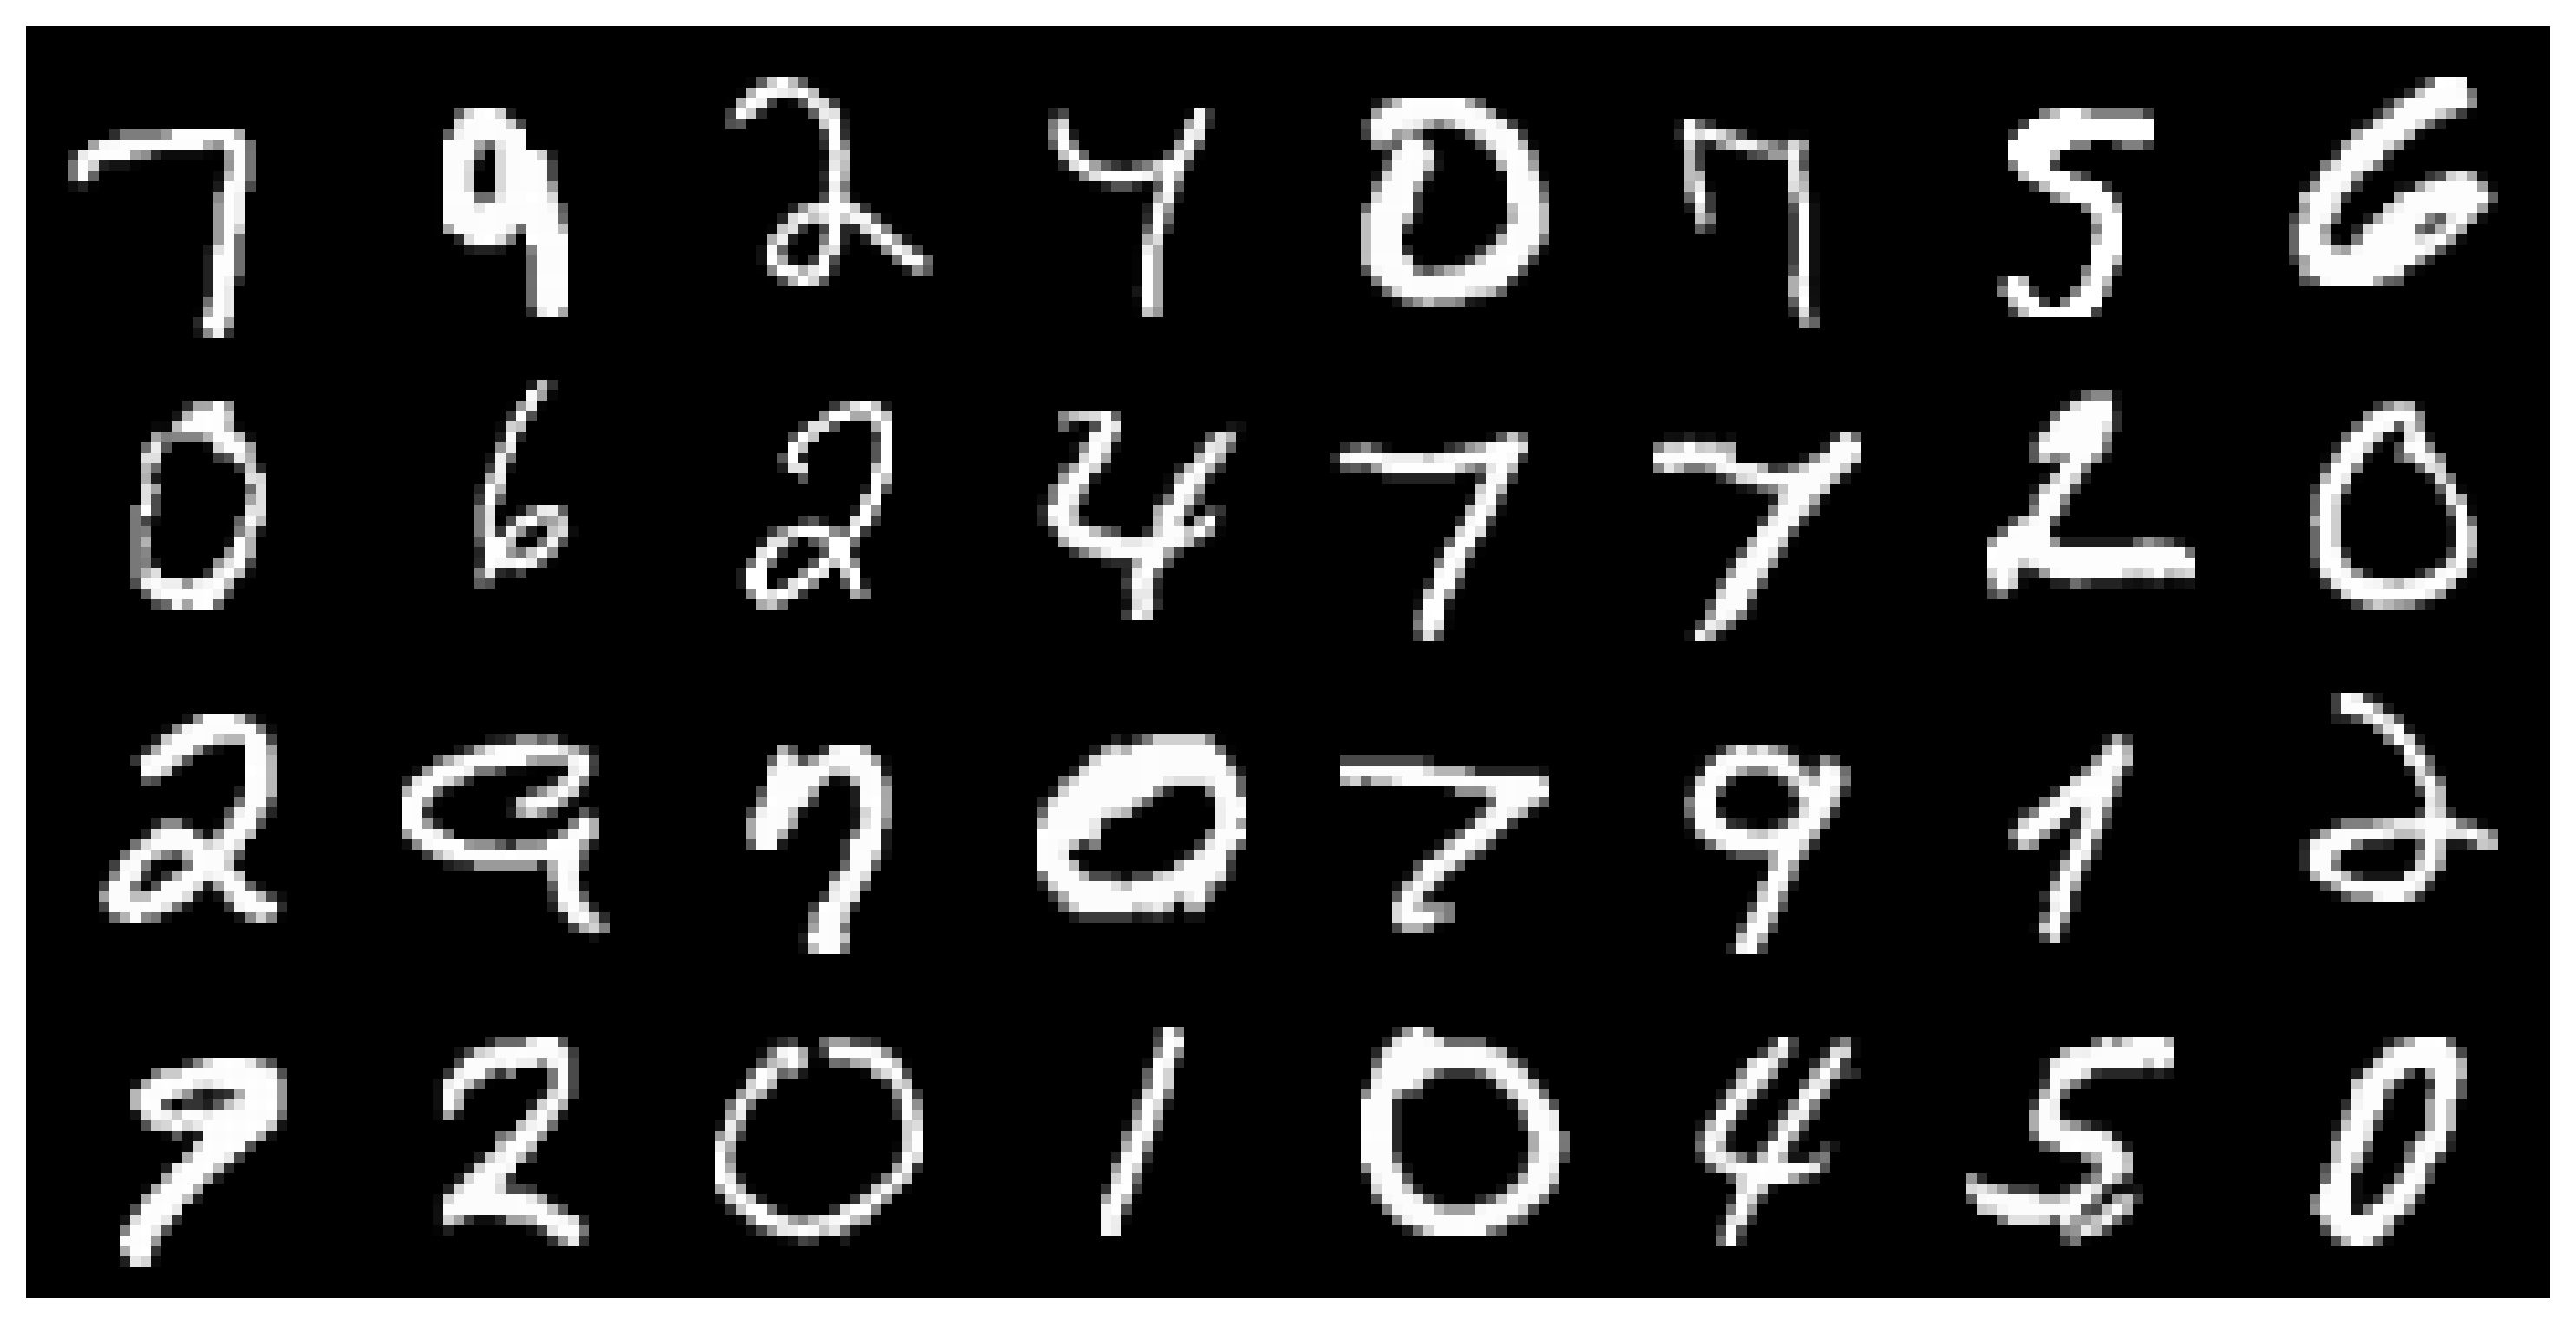

In [6]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(
        figsize=(10, 10),
        dpi=300,
    )
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=plt.cm.gray)
    plt.axis("off")
    fig.tight_layout()
    plt.show()
    
dataiter = iter(model_train_data_loader)
images, _ = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

## Model definition

The CNN model is defined with two convolutional layers, two max-pooling layers, and two fully connected layers.

In [7]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training the model

The model is trained for 20 epochs, with early stopping. The training and validation losses are printed every 100 batches of images. The best model on the validation set is saved.

In [8]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20
patience = 3
patience_counter = patience
best_val_loss = np.inf
best_model = None

for epoch in range(epochs):
    running_loss = 0.0
    print(f"Epoch {epoch + 1}:")
    
    # Training
    model.train()
    for i, (inputs, labels) in enumerate(model_train_data_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'\tTraining loss: {running_loss / inputs.size(0):.4f}')
            running_loss = 0.0

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(model_val_data_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    val_loss /= len(model_val_data_loader)
    print(f'\tValidation loss: {val_loss:.4f}')
    
    # Early stopping and save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = patience
    else:
        patience_counter -= 1
        if patience_counter == 0:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
model = best_model

Epoch 1:
	Training loss: 0.5691
	Training loss: 0.1451
	Validation loss: 0.0969
Epoch 2:
	Training loss: 0.0874
	Training loss: 0.0732
	Validation loss: 0.0613
Epoch 3:
	Training loss: 0.0533
	Training loss: 0.0507
	Validation loss: 0.0578
Epoch 4:
	Training loss: 0.0432
	Training loss: 0.0443
	Validation loss: 0.0435
Epoch 5:
	Training loss: 0.0383
	Training loss: 0.0347
	Validation loss: 0.0390
Epoch 6:
	Training loss: 0.0269
	Training loss: 0.0272
	Validation loss: 0.0424
Epoch 7:
	Training loss: 0.0288
	Training loss: 0.0224
	Validation loss: 0.0339
Epoch 8:
	Training loss: 0.0187
	Training loss: 0.0214
	Validation loss: 0.0318
Epoch 9:
	Training loss: 0.0186
	Training loss: 0.0196
	Validation loss: 0.0353
Epoch 10:
	Training loss: 0.0142
	Training loss: 0.0159
	Validation loss: 0.0397
Epoch 11:
	Training loss: 0.0124
	Training loss: 0.0161
	Validation loss: 0.0416
Early stopping at epoch 11


## Autoencoder definition

The autoencoder is composed of the following parts:

First, an encoder is implemented with a straightforward architecture. It consists of a convolutional section, followed by a flatten layer, and finally, a pair of standard hidden layers that map the output of the convolutional section to the desired embedding dimension.

The decoder is implemented with a similar architecture to the encoder, but in reverse. It consists of a pair of standard hidden layers, followed by an unflatten layer, and finally, a convolutional section that maps the output of the hidden layers to the original dimensionality of the input.

In [9]:
class Encoder(nn.Module):

    def __init__(self, embedding_dim: int):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [10]:
class Decoder(nn.Module):

    def __init__(self, embedding_dim: int):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class Autoencoder(nn.Module):

    def __init__(self, embedding_dim: int) -> None:
        super().__init__()
        self.encoder = Encoder(
            embedding_dim=embedding_dim,
        )
        self.decoder = Decoder(
            embedding_dim=embedding_dim,
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## Training the autoencoder

To prevent the autoencoder from simply learning to copy the input to the output (acting as an identity function), we implement the contractive loss as a regularizer to learn a meaningful representation of the input in the embedding dimensions {cite:p}`rifai2011contractive`. For optimization, Adam {cite:p}`kingma2014adam` is used.

In [12]:
def contractive_loss(outputs_e, outputs, inputs, lambda_ = 1e-4):
    assert outputs.shape == inputs.shape ,f'outputs.shape : {outputs.shape} != inputs.shape : {inputs.shape}'
    criterion = nn.MSELoss()
    loss1 = criterion(outputs, inputs)

    outputs_e.backward(torch.ones(outputs_e.size()), retain_graph=True)
    loss2 = torch.sqrt(torch.sum(torch.pow(inputs.grad, 2)))
    inputs.grad.data.zero_()

    loss = loss1 + (lambda_*loss2)
    return loss

The embedding dimension is set to 5, and the autoencoder is trained for 20 epochs, with early stopping. The training and validation losses are printed every 100 batches of images.

In [13]:
embedding_dim = 5
autoencoder = Autoencoder(
    embedding_dim=embedding_dim,
).to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

epochs = 20
patience = 3
patience_counter = patience
best_val_loss = np.inf
best_autoencoder = None

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}:")
    running_loss = 0.0
    
    # Training
    autoencoder.train()
    for i, (inputs, _) in enumerate(autoencoder_train_data_loader, 0):
        inputs = inputs.to(device)
        inputs.requires_grad = True
        inputs.retain_grad()

        outputs_e, outputs = autoencoder(inputs)
        loss = contractive_loss(outputs_e, outputs, inputs)

        inputs.requires_grad = False

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'\tTraining loss: {running_loss / inputs.size(0):.4f}')
            running_loss = 0.0
            
    # Validation
    autoencoder.eval()
    val_loss = 0.0
    # with torch.no_grad() is not used here to allow for the calculation of the gradient of the inputs
    for i, (inputs, _) in enumerate(autoencoder_val_data_loader, 0):
        inputs = inputs.to(device)
        inputs.requires_grad = True
        inputs.retain_grad()

        outputs_e, outputs = autoencoder(inputs)
        loss = contractive_loss(outputs_e, outputs, inputs)

        inputs.requires_grad = False

        val_loss += loss.item()
            
    val_loss /= len(autoencoder_val_data_loader)
    print(f'\tValidation loss: {val_loss:.4f}')
    
    # Early stopping and save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_autoencoder = copy.deepcopy(autoencoder)
        patience_counter = patience
    else:
        patience_counter -= 1
        if patience_counter == 0:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
autoencoder = best_autoencoder

Epoch 1:
	Training loss: 0.1349
	Validation loss: 0.1109
Epoch 2:
	Training loss: 0.0712
	Validation loss: 0.0705
Epoch 3:
	Training loss: 0.0473
	Validation loss: 0.0494
Epoch 4:
	Training loss: 0.0350
	Validation loss: 0.0399
Epoch 5:
	Training loss: 0.0295
	Validation loss: 0.0353
Epoch 6:
	Training loss: 0.0265
	Validation loss: 0.0327
Epoch 7:
	Training loss: 0.0250
	Validation loss: 0.0315
Epoch 8:
	Training loss: 0.0238
	Validation loss: 0.0305
Epoch 9:
	Training loss: 0.0232
	Validation loss: 0.0298
Epoch 10:
	Training loss: 0.0226
	Validation loss: 0.0293
Epoch 11:
	Training loss: 0.0222
	Validation loss: 0.0288
Epoch 12:
	Training loss: 0.0219
	Validation loss: 0.0284
Epoch 13:
	Training loss: 0.0216
	Validation loss: 0.0280
Epoch 14:
	Training loss: 0.0214
	Validation loss: 0.0278
Epoch 15:
	Training loss: 0.0210
	Validation loss: 0.0275
Epoch 16:
	Training loss: 0.0209
	Validation loss: 0.0276
Epoch 17:
	Training loss: 0.0206
	Validation loss: 0.0272
Epoch 18:
	Training los

A sample is shown below, featuring the reconstruction made by the autoencoder from the 5 embedding dimensions with a sample not seen during training.

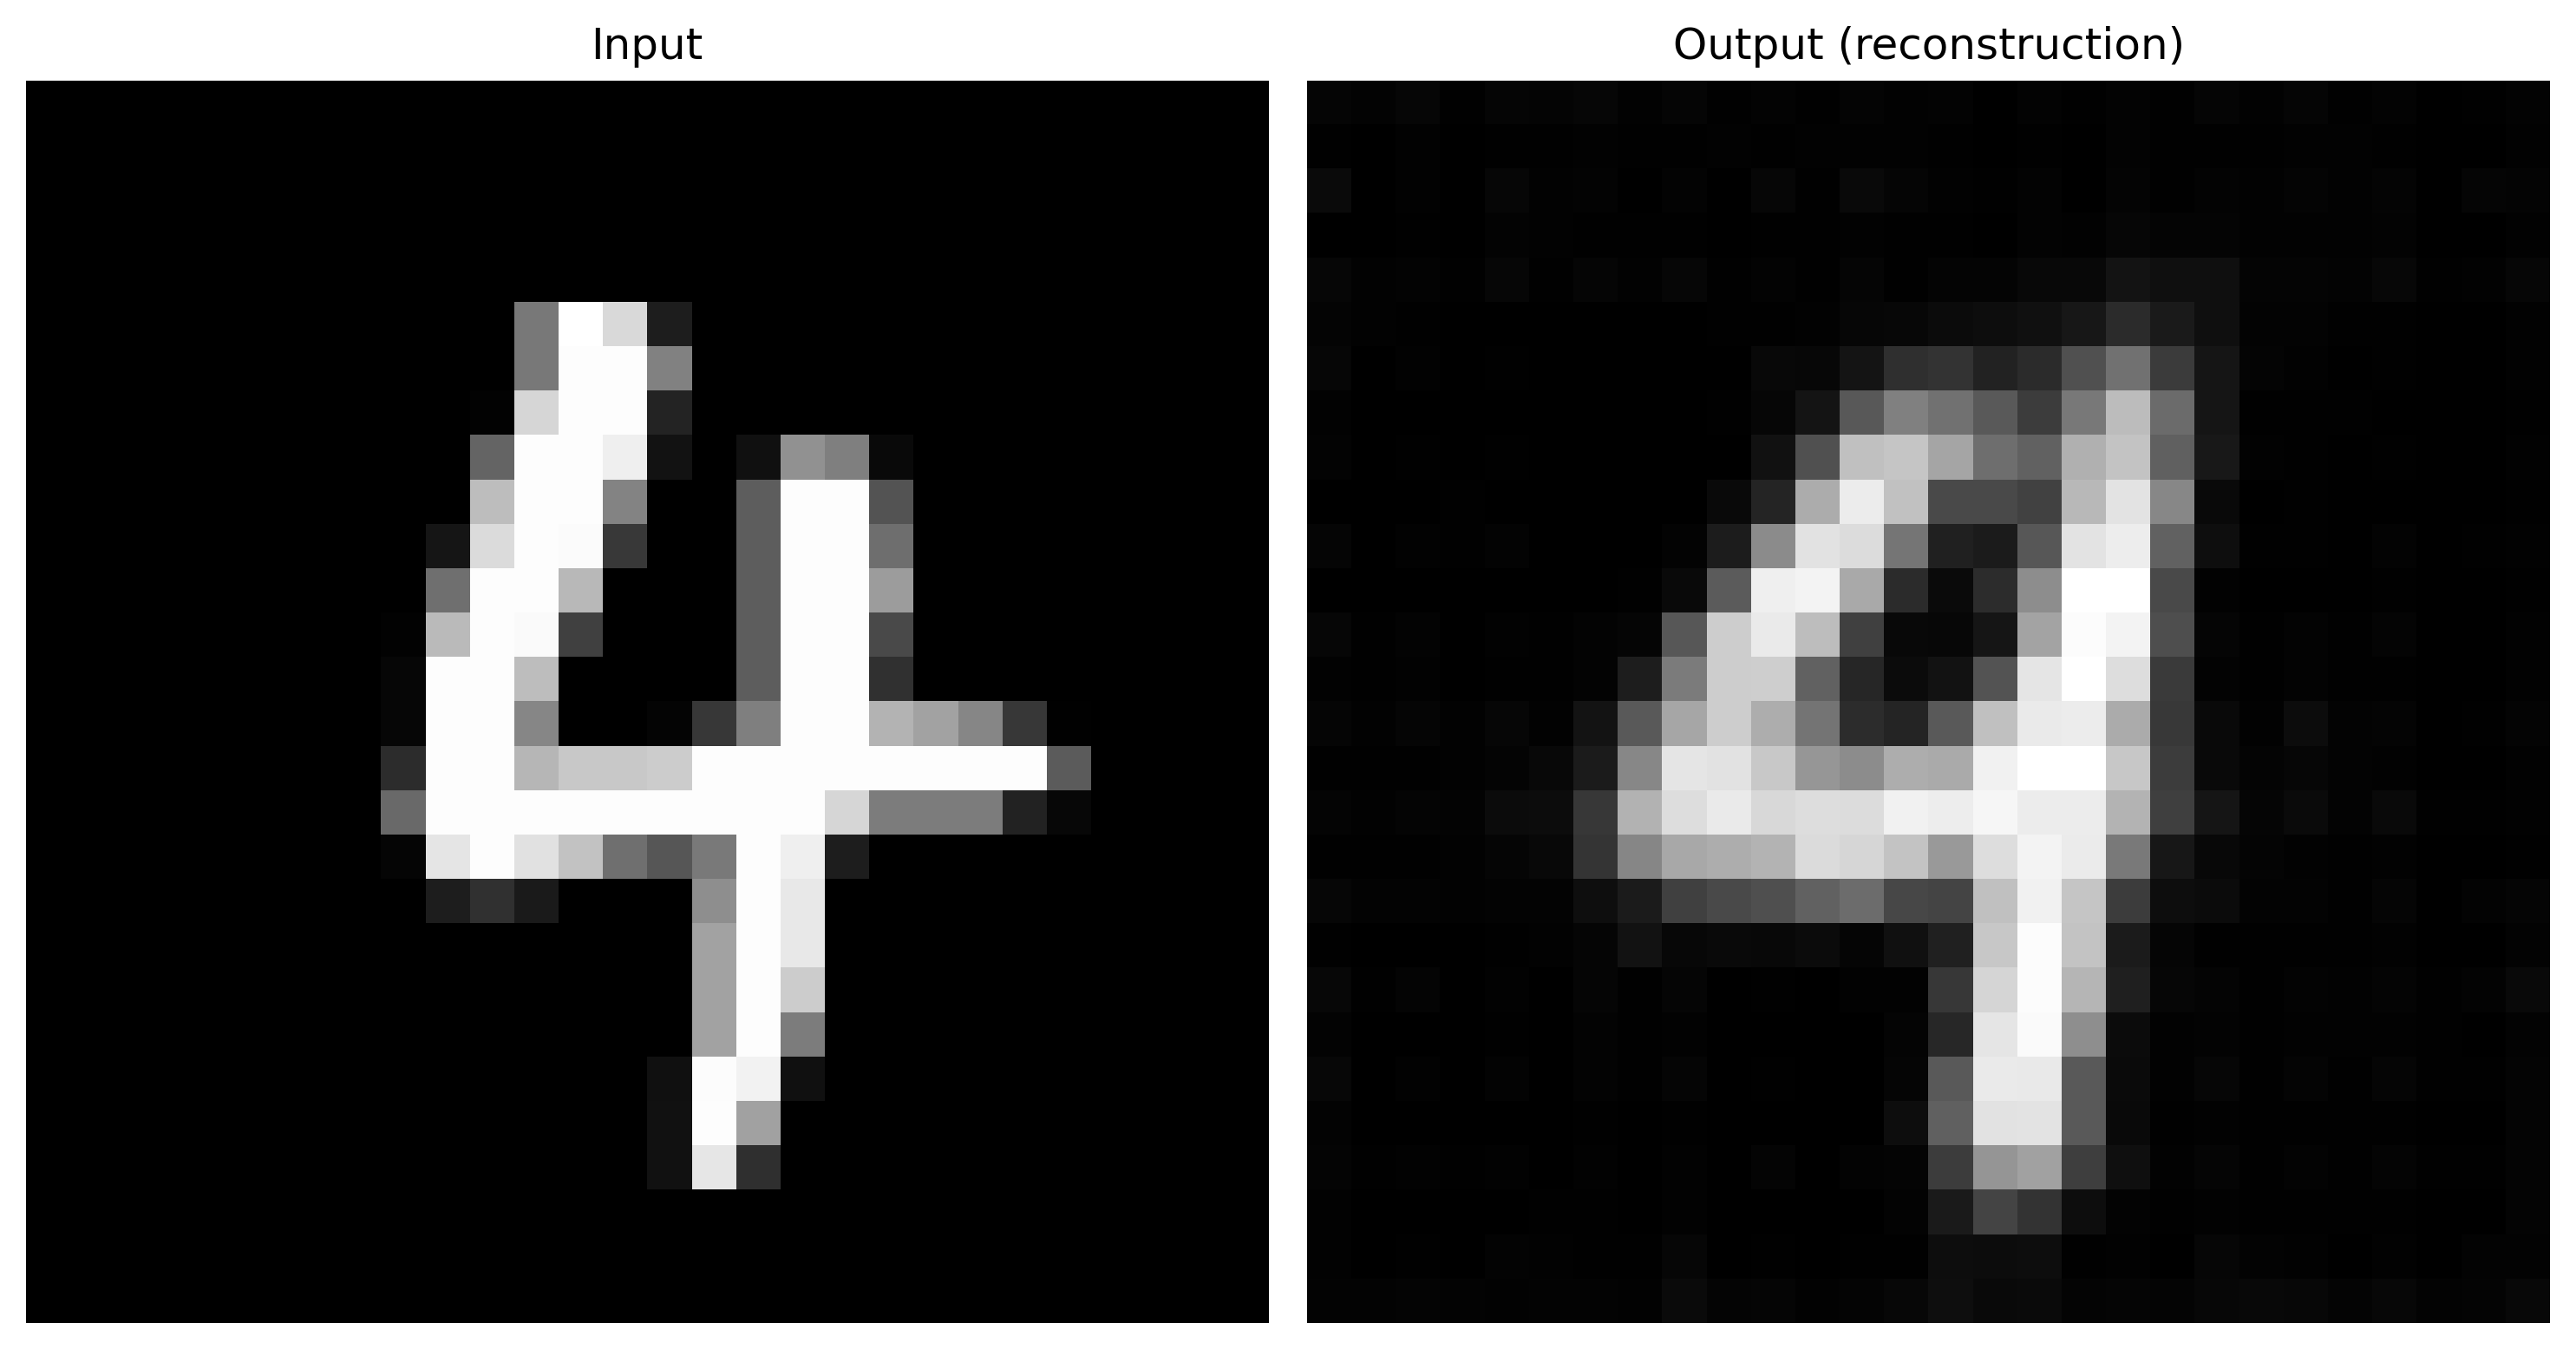

In [14]:
sample = reference_dataset[1][0]  # Sample not seen by the autoencoder during training
_, X_reconstructed = autoencoder(sample.unsqueeze(0))
X_reconstructed = torch.squeeze(X_reconstructed, axis=0)

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 10),
    dpi=300,
)

axs[0].set_title("Input")
axs[0].imshow(np.transpose(sample, (1, 2, 0)), cmap=plt.cm.gray)
axs[0].axis("off")

axs[1].set_title("Output (reconstruction)")
axs[1].imshow(np.transpose(X_reconstructed.detach(), (1, 2, 0)), cmap=plt.cm.gray)
axs[1].axis("off")

fig.tight_layout()
plt.show()

## Custom dataset definition

To apply each transformation to the images, a custom dataset class is utilized.

In [15]:
class CustomMNIST(Dataset):

    def __init__(
        self,
        subset,
        transform: Optional[Union[torch.nn.Module, torchvision.transforms.Compose]] = None
    ) -> None:
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self) -> int:
        return len(self.subset)

Apply GaussianBlur and ElasticTransform transformations to the test dataset.

In [16]:
gaussian_blur_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.GaussianBlur(
                kernel_size=(5, 9),
                sigma=1.5,
            ),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

elastic_transform_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.ElasticTransform(
                alpha=100.0,
                sigma=5.0,
            ),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

Some images from the original, GaussianBlur, and ElasticTransform datasets are shown below to see the effect of the transformations.

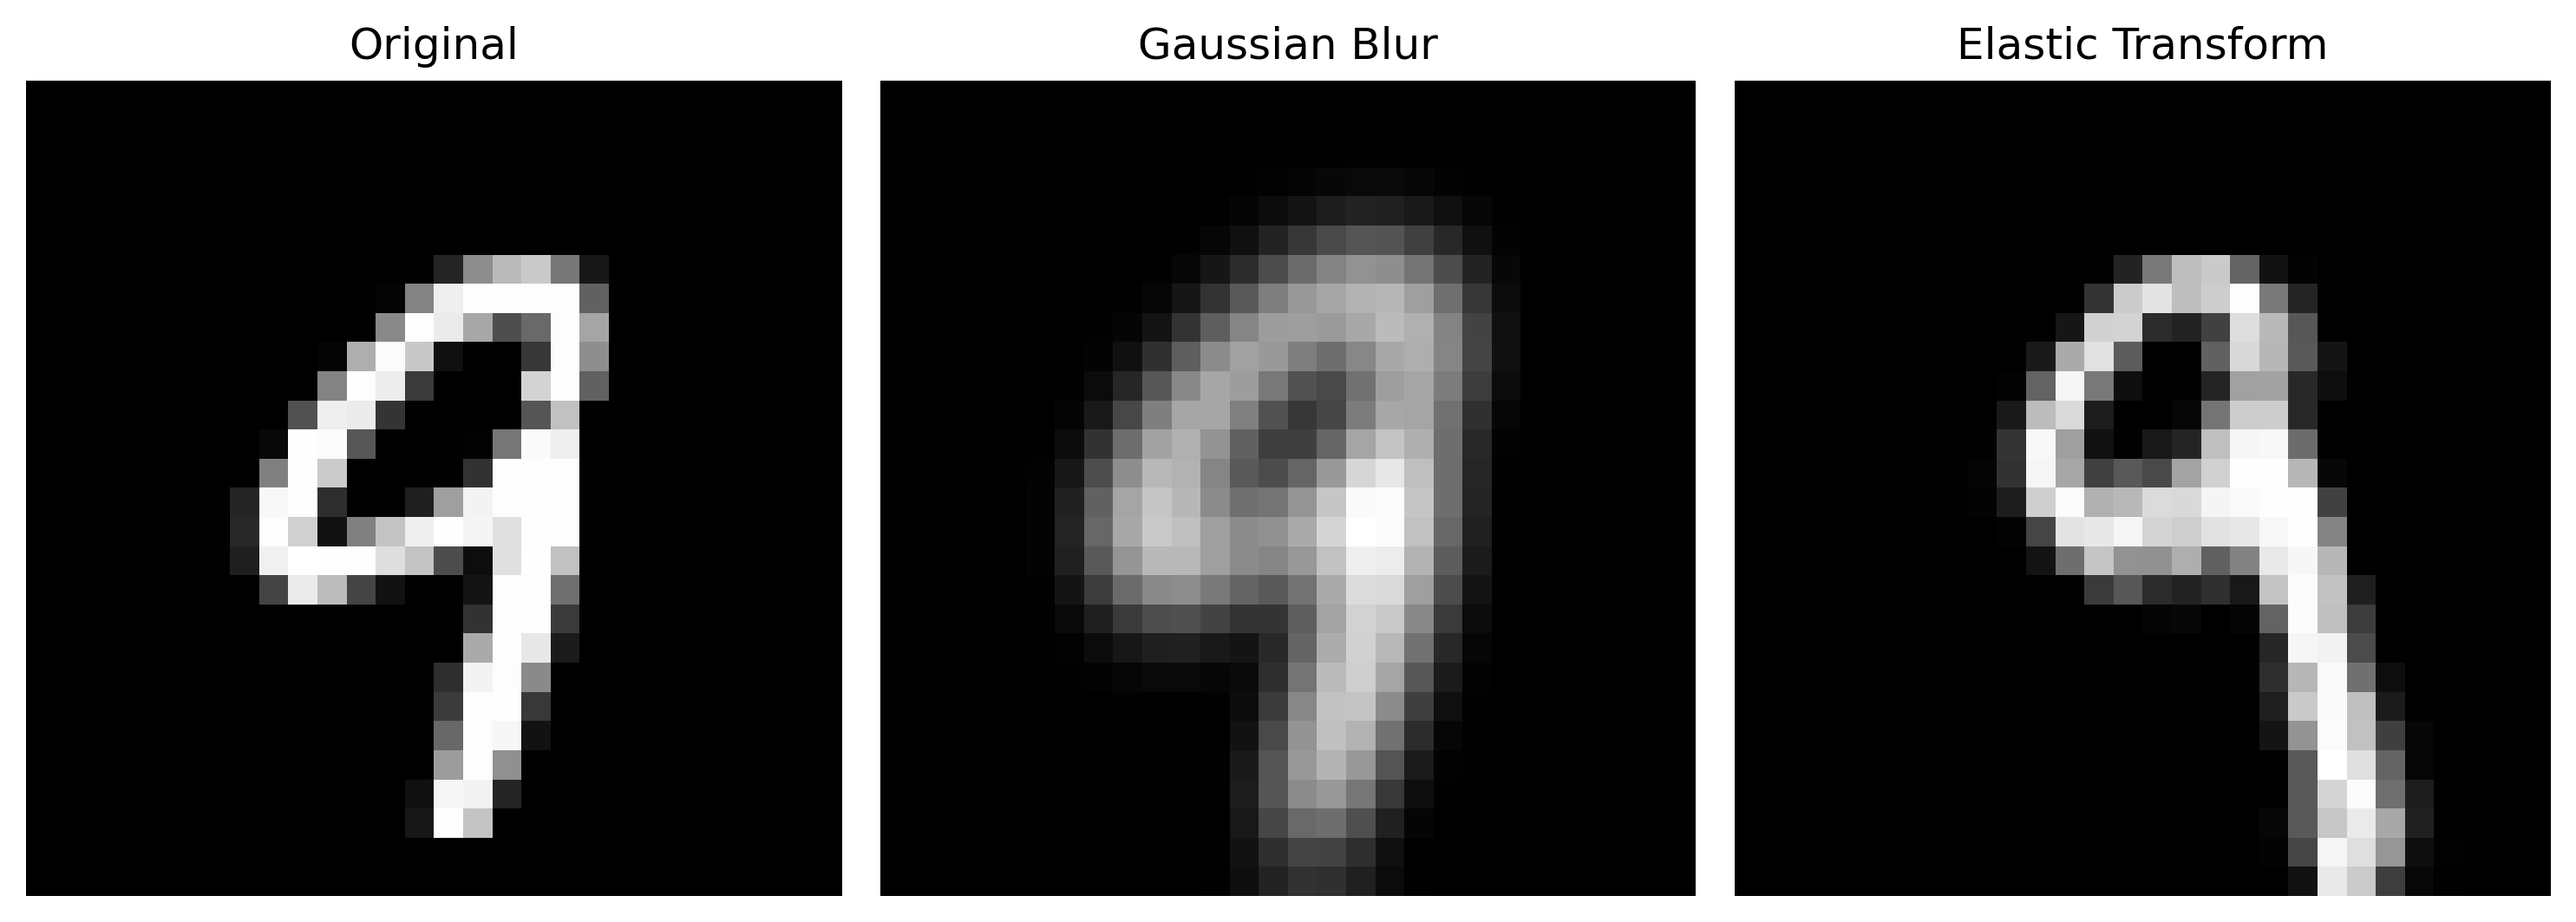

In [17]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(10, 10),
    dpi=300,
)

for ax, img, title in zip(
        axs.flat,
        [
            test_dataset[0][0],
            gaussian_blur_dataset[0][0],
            elastic_transform_dataset[0][0]],
        [
            "Original",
            "Gaussian Blur",
            "Elastic Transform",
        ],
):
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap=plt.cm.gray)
    ax.set_title(title)
    ax.axis("off")

fig.tight_layout()
plt.show()

## Test the model

The accuracy of the model is tested with the original, GaussianBlur, and ElasticTransform datasets. The goal is to verify if the model is affected by the transformations.

In [18]:
def test_model_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [19]:
# Test model with test dataset
model_test_original_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

model_test_gaussian_blur_data_loader = torch.utils.data.DataLoader(
    dataset=gaussian_blur_dataset,
    batch_size=batch_size,
    shuffle=False,
)

model_test_elastic_transform_data_loader = torch.utils.data.DataLoader(
    dataset=elastic_transform_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [20]:
for data_loader, type_ in zip(
        [
            model_test_original_data_loader,
            model_test_gaussian_blur_data_loader, 
            model_test_elastic_transform_data_loader,
        ], [
            "Original",
            "Gaussian Blur",
            "Elastic Transform",
        ],
):
    accuracy = test_model_accuracy(
        model=model,
        data_loader=data_loader,
    )
    print(f"{type_} accuracy: {accuracy:.2f}%")

Original accuracy: 98.98%
Gaussian Blur accuracy: 96.71%
Elastic Transform accuracy: 82.61%


As we can see, the model's accuracy is affected by the transformations, with the GaussianBlur and ElasticTransform datasets showing a significant decrease in accuracy with respect to the original (unmodified) dataset.

## Data drift detection

Finally, the data drift detector is applied to the original, GaussianBlur, and ElasticTransform datasets. The goal is to verify if the detector can detect the drift caused by the transformations.

Each dataset is converted to a numpy array to be used as input for the MMD detector.

In [21]:
X_ref_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(reference_dataset)]).astype(np.float32)

idx_test_sample = np.random.choice(np.arange(0, len(test_dataset)), size=reference_dataset_size, replace=False)
X_test_original_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(test_dataset, idx_test_sample))]).astype(np.float32)
X_test_gaussian_blur_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(gaussian_blur_dataset, idx_test_sample))]).astype(np.float32)
X_test_elastic_transform_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(elastic_transform_dataset, idx_test_sample))]).astype(np.float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The reference dataset and the test datasets are encoded using the autoencoder. Therefore, the original 784 dimensions are reduced to 5 dimensions.

In [22]:
with torch.no_grad():
    # Reference dataset
    X_ref_encoded = autoencoder.encoder(torch.Tensor(X_ref_sample)).numpy()
    # Test datasets
    X_test_original_encoded = autoencoder.encoder(torch.Tensor(X_test_original_sample)).numpy()
    X_test_gaussian_blur_encoded = autoencoder.encoder(torch.Tensor(X_test_gaussian_blur_sample)).numpy()
    X_test_elastic_transform_encoded = autoencoder.encoder(torch.Tensor(X_test_elastic_transform_sample)).numpy()

The distribution of each embedding dimension is plotted for each test dataset and the reference. The goal is to visually inspect the differences between the distributions of the reference and each test dataset.

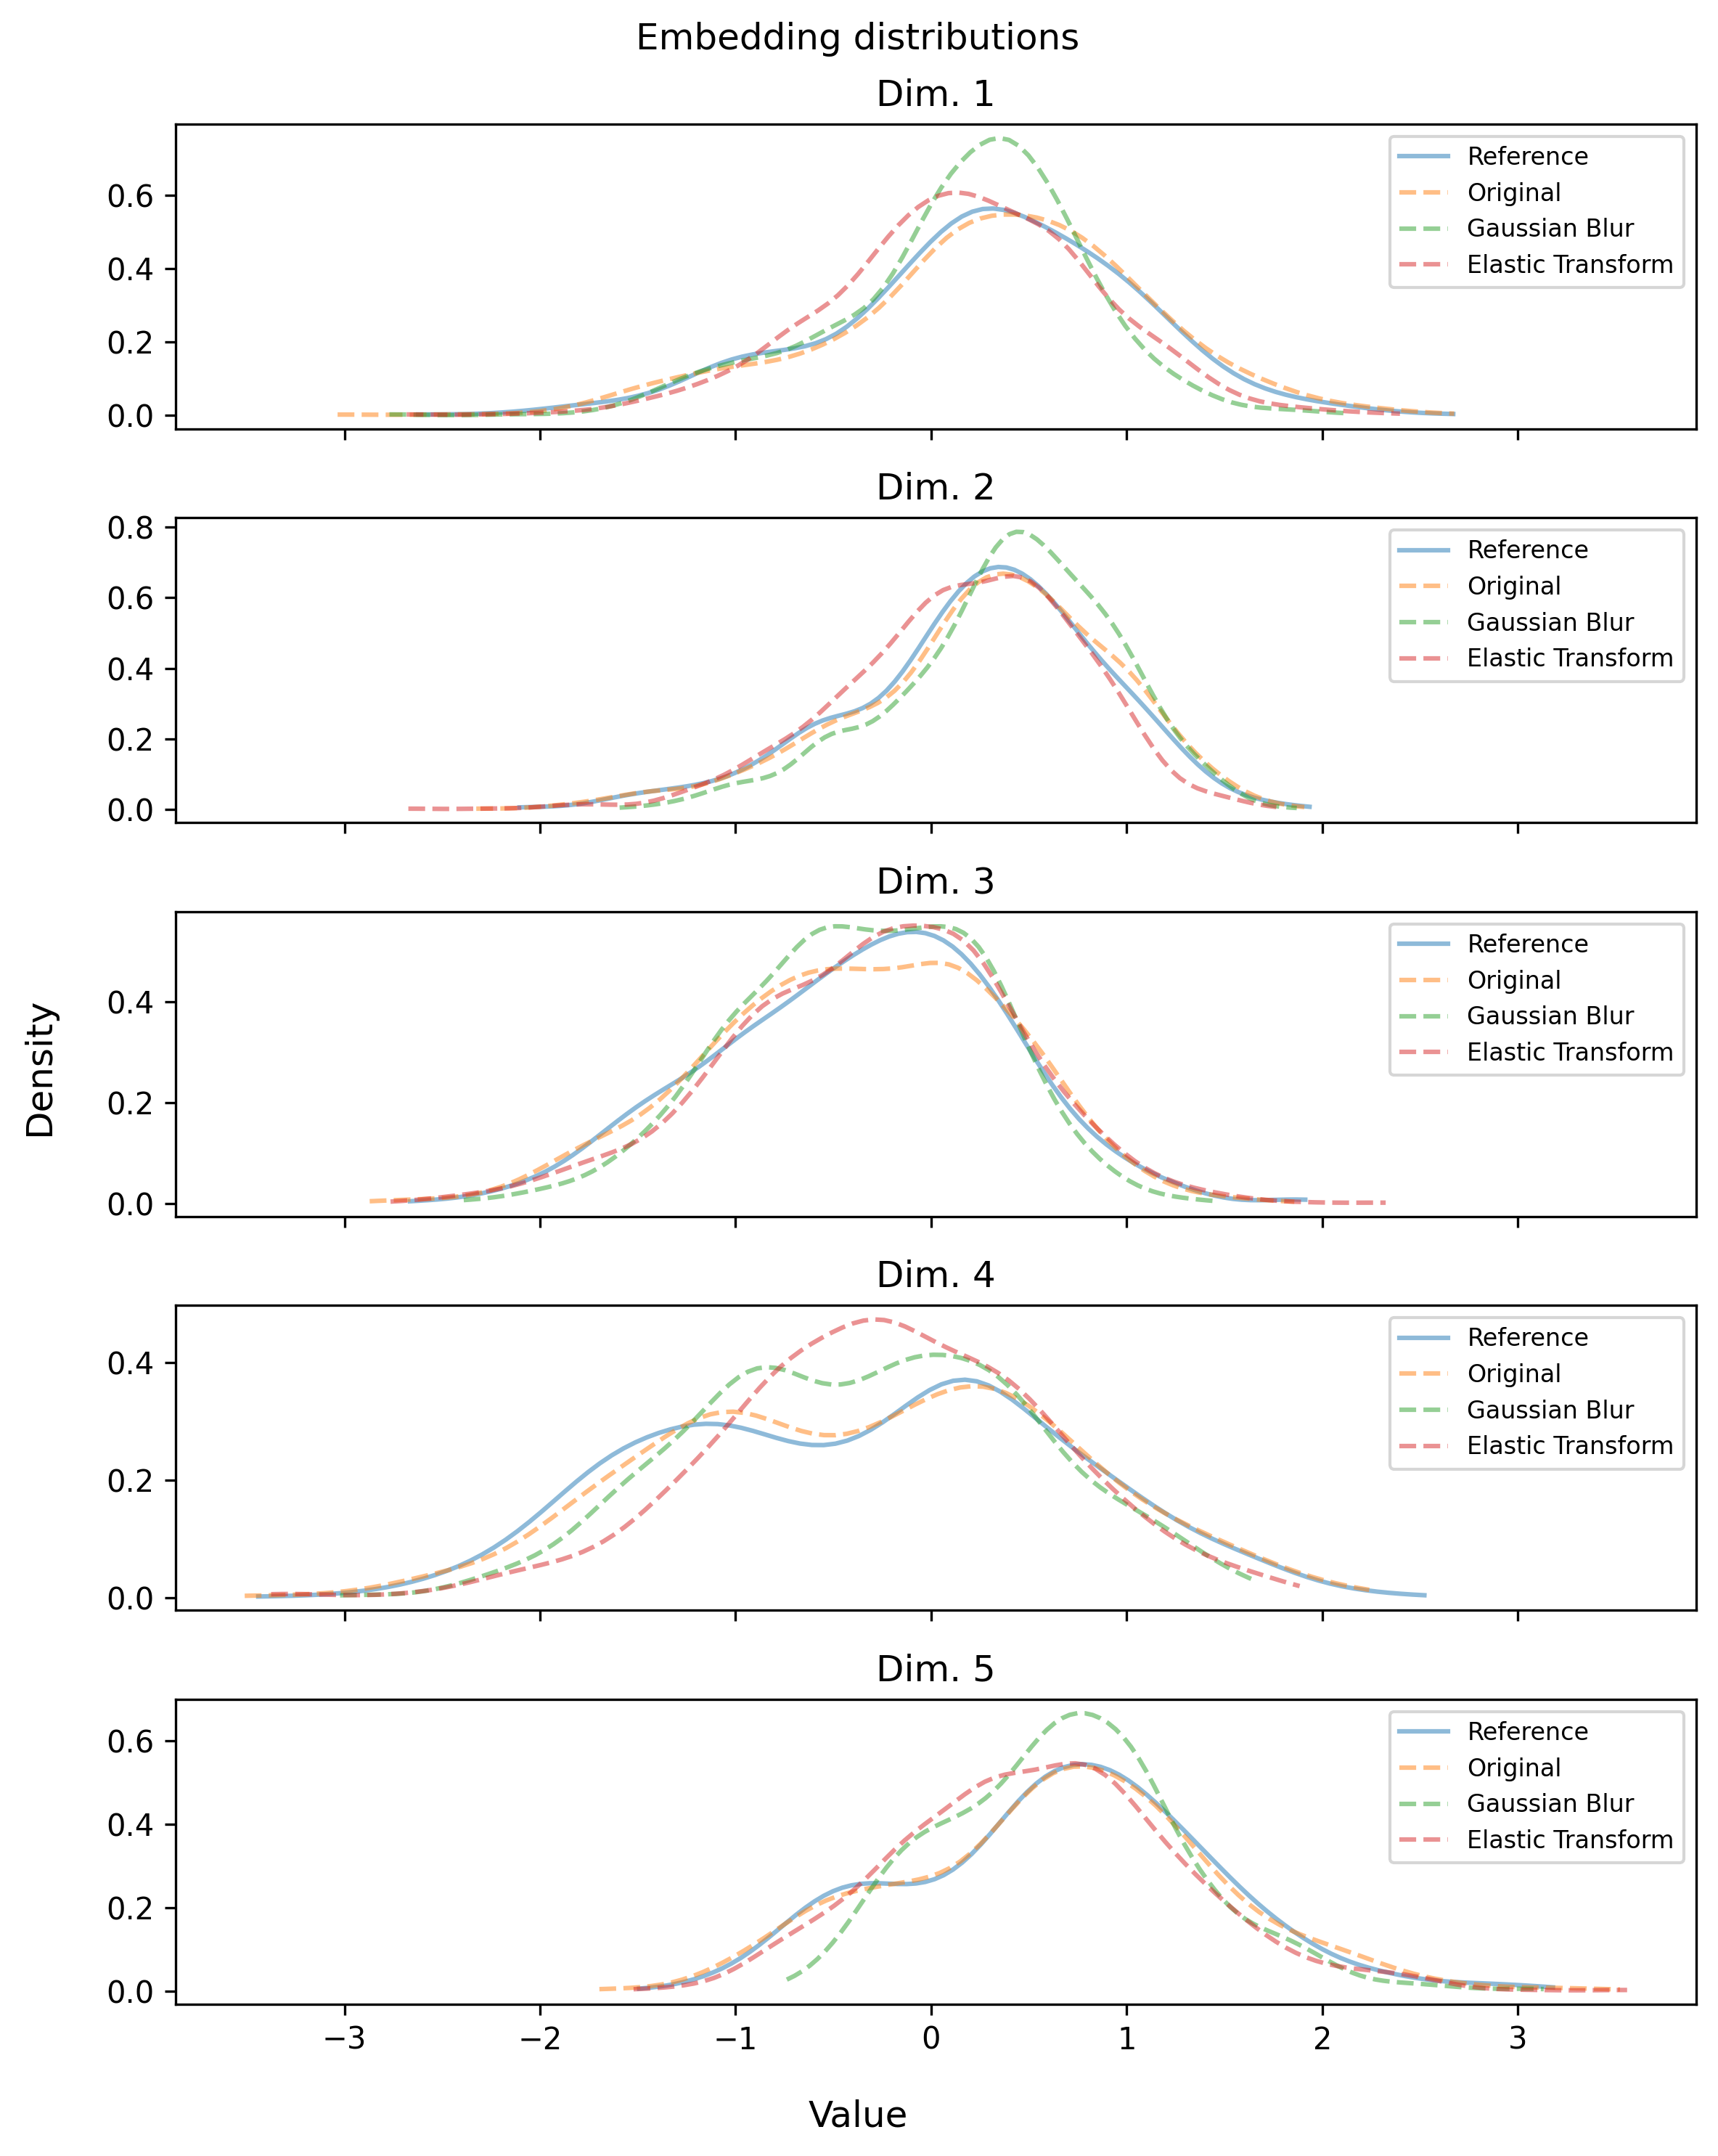

In [23]:
x_values = 100
fig, axs = plt.subplots(
    nrows=embedding_dim,
    ncols=1,
    figsize=(8, 10),
    sharex=True,
    dpi=300,
)

for i, ax in enumerate(axs.flat):
    for sample, type_ in zip(
            [
                X_ref_encoded[:, i],
                X_test_original_encoded[:, i],
                X_test_gaussian_blur_encoded[:, i],
                X_test_elastic_transform_encoded[:, i],
            ], 
            [
                "Reference",
                "Original",
                "Gaussian Blur",
                "Elastic Transform",
            ],
    ):
        xs = np.linspace(np.min(sample), np.max(sample), num=x_values)
        permutation_tests_density = gaussian_kde(sample).evaluate(xs)
        ax.plot(xs, permutation_tests_density, alpha=0.5, label=type_, linestyle="--" if type_ != "Reference" else None)
    ax.set_title(f"Dim. {i+1}")
    ax.legend(fontsize=8)

fig.suptitle("Embedding distributions")
fig.supxlabel("Value")
fig.supylabel("Density")
fig.tight_layout()

plt.show()

We can see that the distributions of the GaussianBlur and ElasticTransform datasets are different from the reference dataset. The original dataset, however, has a distribution that is similar to the reference dataset for each embedding dimension.

A significance level of $\alpha = 0.01$ is set for the hypothesis test.

In [24]:
alpha = 0.01

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a`, imported from Frouros, is utilized with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, the p-value is estimated using a permutation test with 5,000 permutations.

**Note:**
Since a rbf kernel is used, the median of the pairwise distances between the reference dataset is used as the bandwidth parameter $\sigma$.

In [25]:
sigma = np.median(
        pdist(
            X=X_ref_encoded,
            metric="euclidean",
        ),
    )
sigma

2.3344805355706737

In [26]:
num_permutations = 5000

detector = MMD(
    kernel=partial(
        rbf_kernel,
        sigma=sigma,
    ),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=num_permutations,
            random_state=seed,
            num_jobs=-1,
            name="permutation_test",
            conservative=True,
            verbose=False,
        ),
    ],
)
_ = detector.fit(X=X_ref_encoded)

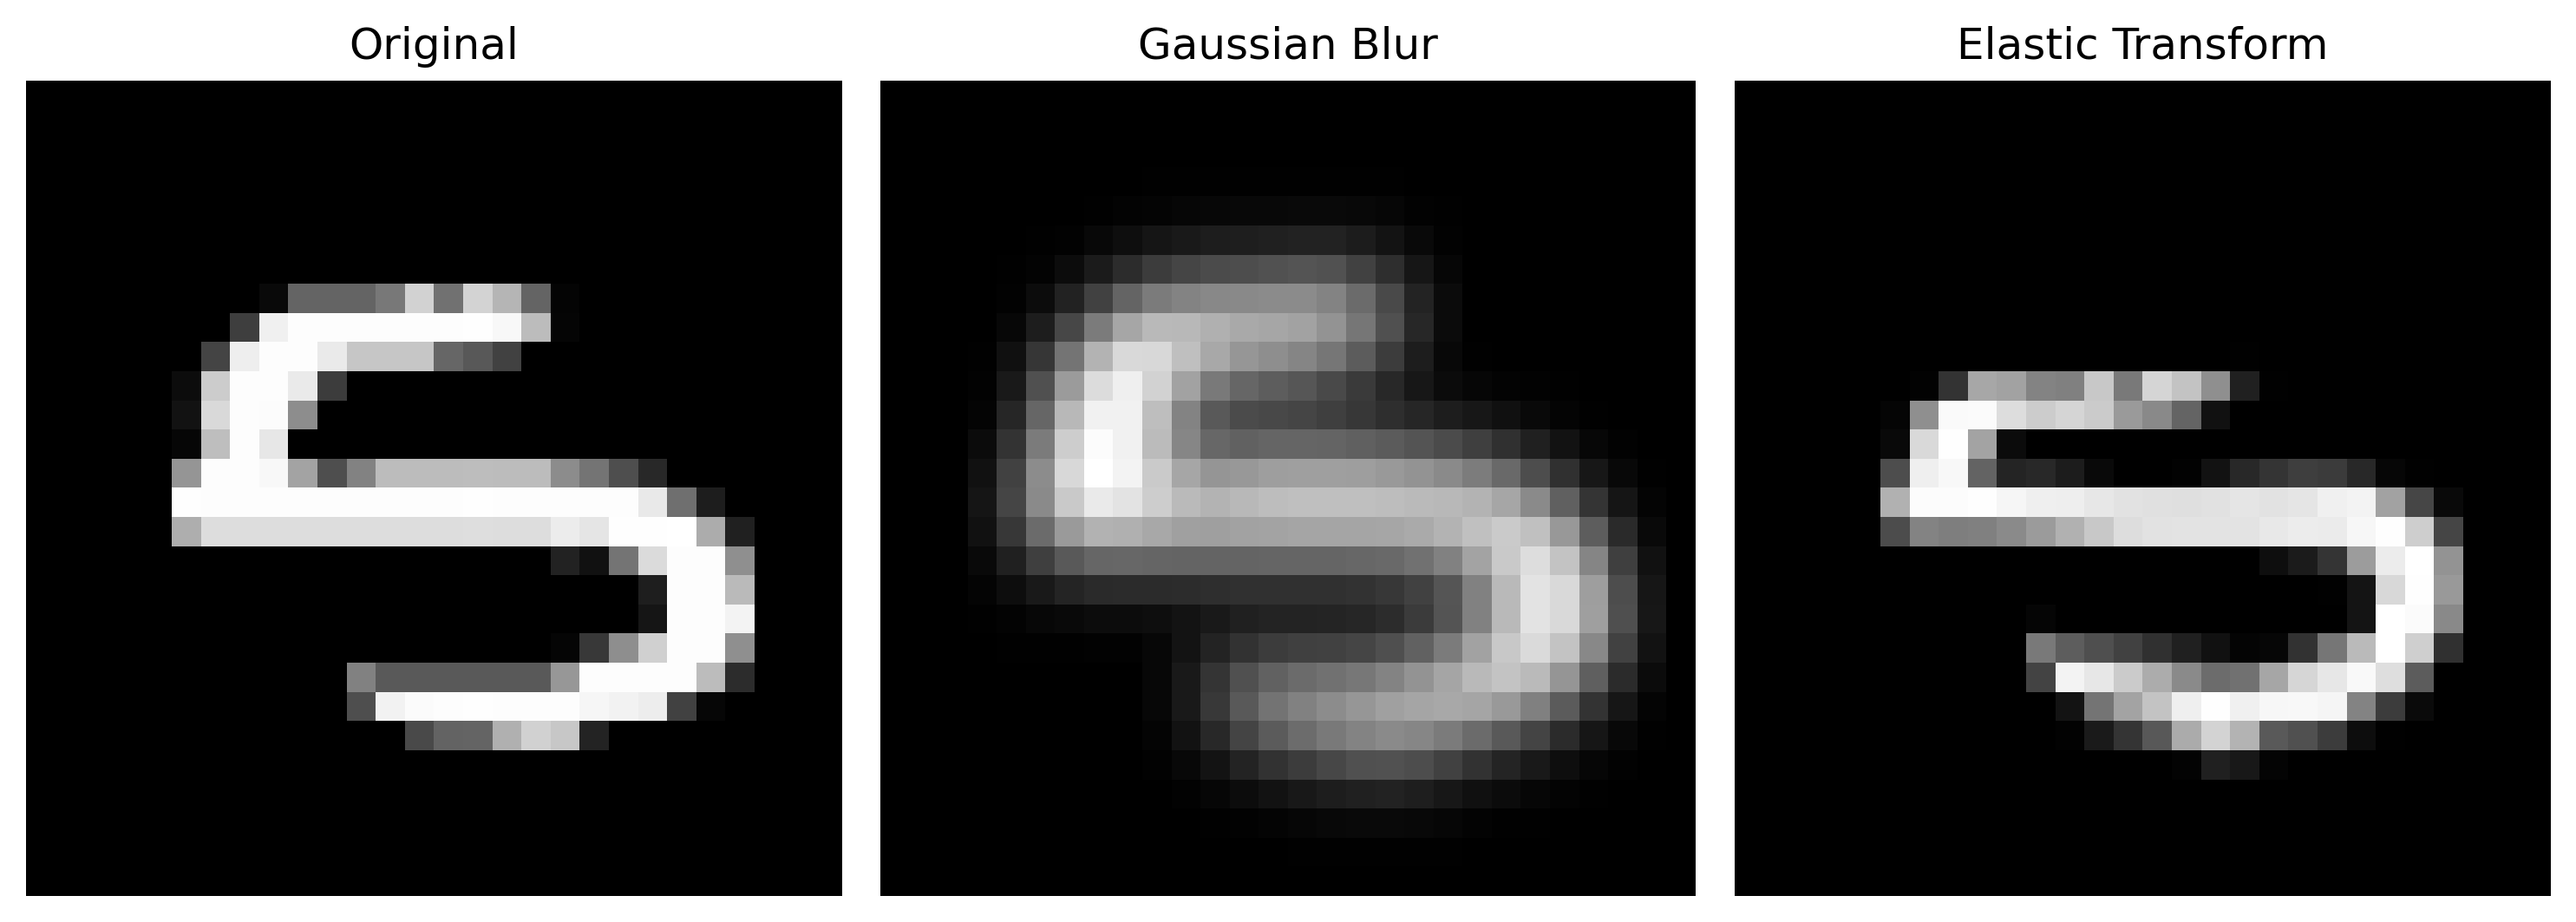

In [27]:
idx = 10

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(10, 10),
    dpi=300,
)

axs[0].set_title("Original")
axs[0].imshow(np.transpose(X_test_original_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)
axs[0].axis("off")

axs[1].set_title("Gaussian Blur")
axs[1].imshow(np.transpose(X_test_gaussian_blur_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)
axs[1].axis("off")

axs[2].set_title("Elastic Transform")
axs[2].imshow(np.transpose(X_test_elastic_transform_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)
axs[2].axis("off")

fig.tight_layout()
plt.show()

The MMD statistic and p-value are calculated for each test dataset. The p-value is used to determine if the test dataset is significantly different from the reference dataset. If the p-value is less than or equal to the significance level $\alpha$, the test dataset is considered to exhibit drift.

In [28]:
permutation_test_logs = {}

for sample, type_ in zip(
        [
            X_test_original_encoded,
            X_test_gaussian_blur_encoded,
            X_test_elastic_transform_encoded,
        ], 
        [
            "Original (unmodified)",
            "Gaussian Blur",
            "Elastic Transform",
        ],
):
    mmd, callbacks_logs = detector.compare(X=sample)
    permutation_test_logs[type_] = copy.copy(callbacks_logs["permutation_test"])
    mmd, p_value = mmd.distance, callbacks_logs["permutation_test"]["p_value"]
    print(f"{type_}:\n\tMMD statistic={round(mmd, 4)}, p-value={round(p_value, 4)}, drift={p_value <= alpha}")

Original (unmodified):
	MMD statistic=-0.0003, p-value=0.7219, drift=False
Gaussian Blur:
	MMD statistic=0.0083, p-value=0.0002, drift=True
Elastic Transform:
	MMD statistic=0.0075, p-value=0.0002, drift=True


As expected, the GaussianBlur and ElasticTransform datasets exhibit a significant difference (drift) from the reference dataset. Conversely, unmodified samples are confirmed to be from the same distribution as the reference dataset (no drift).

Finally, the MMD statistic and permutation test results are plotted for each test dataset.

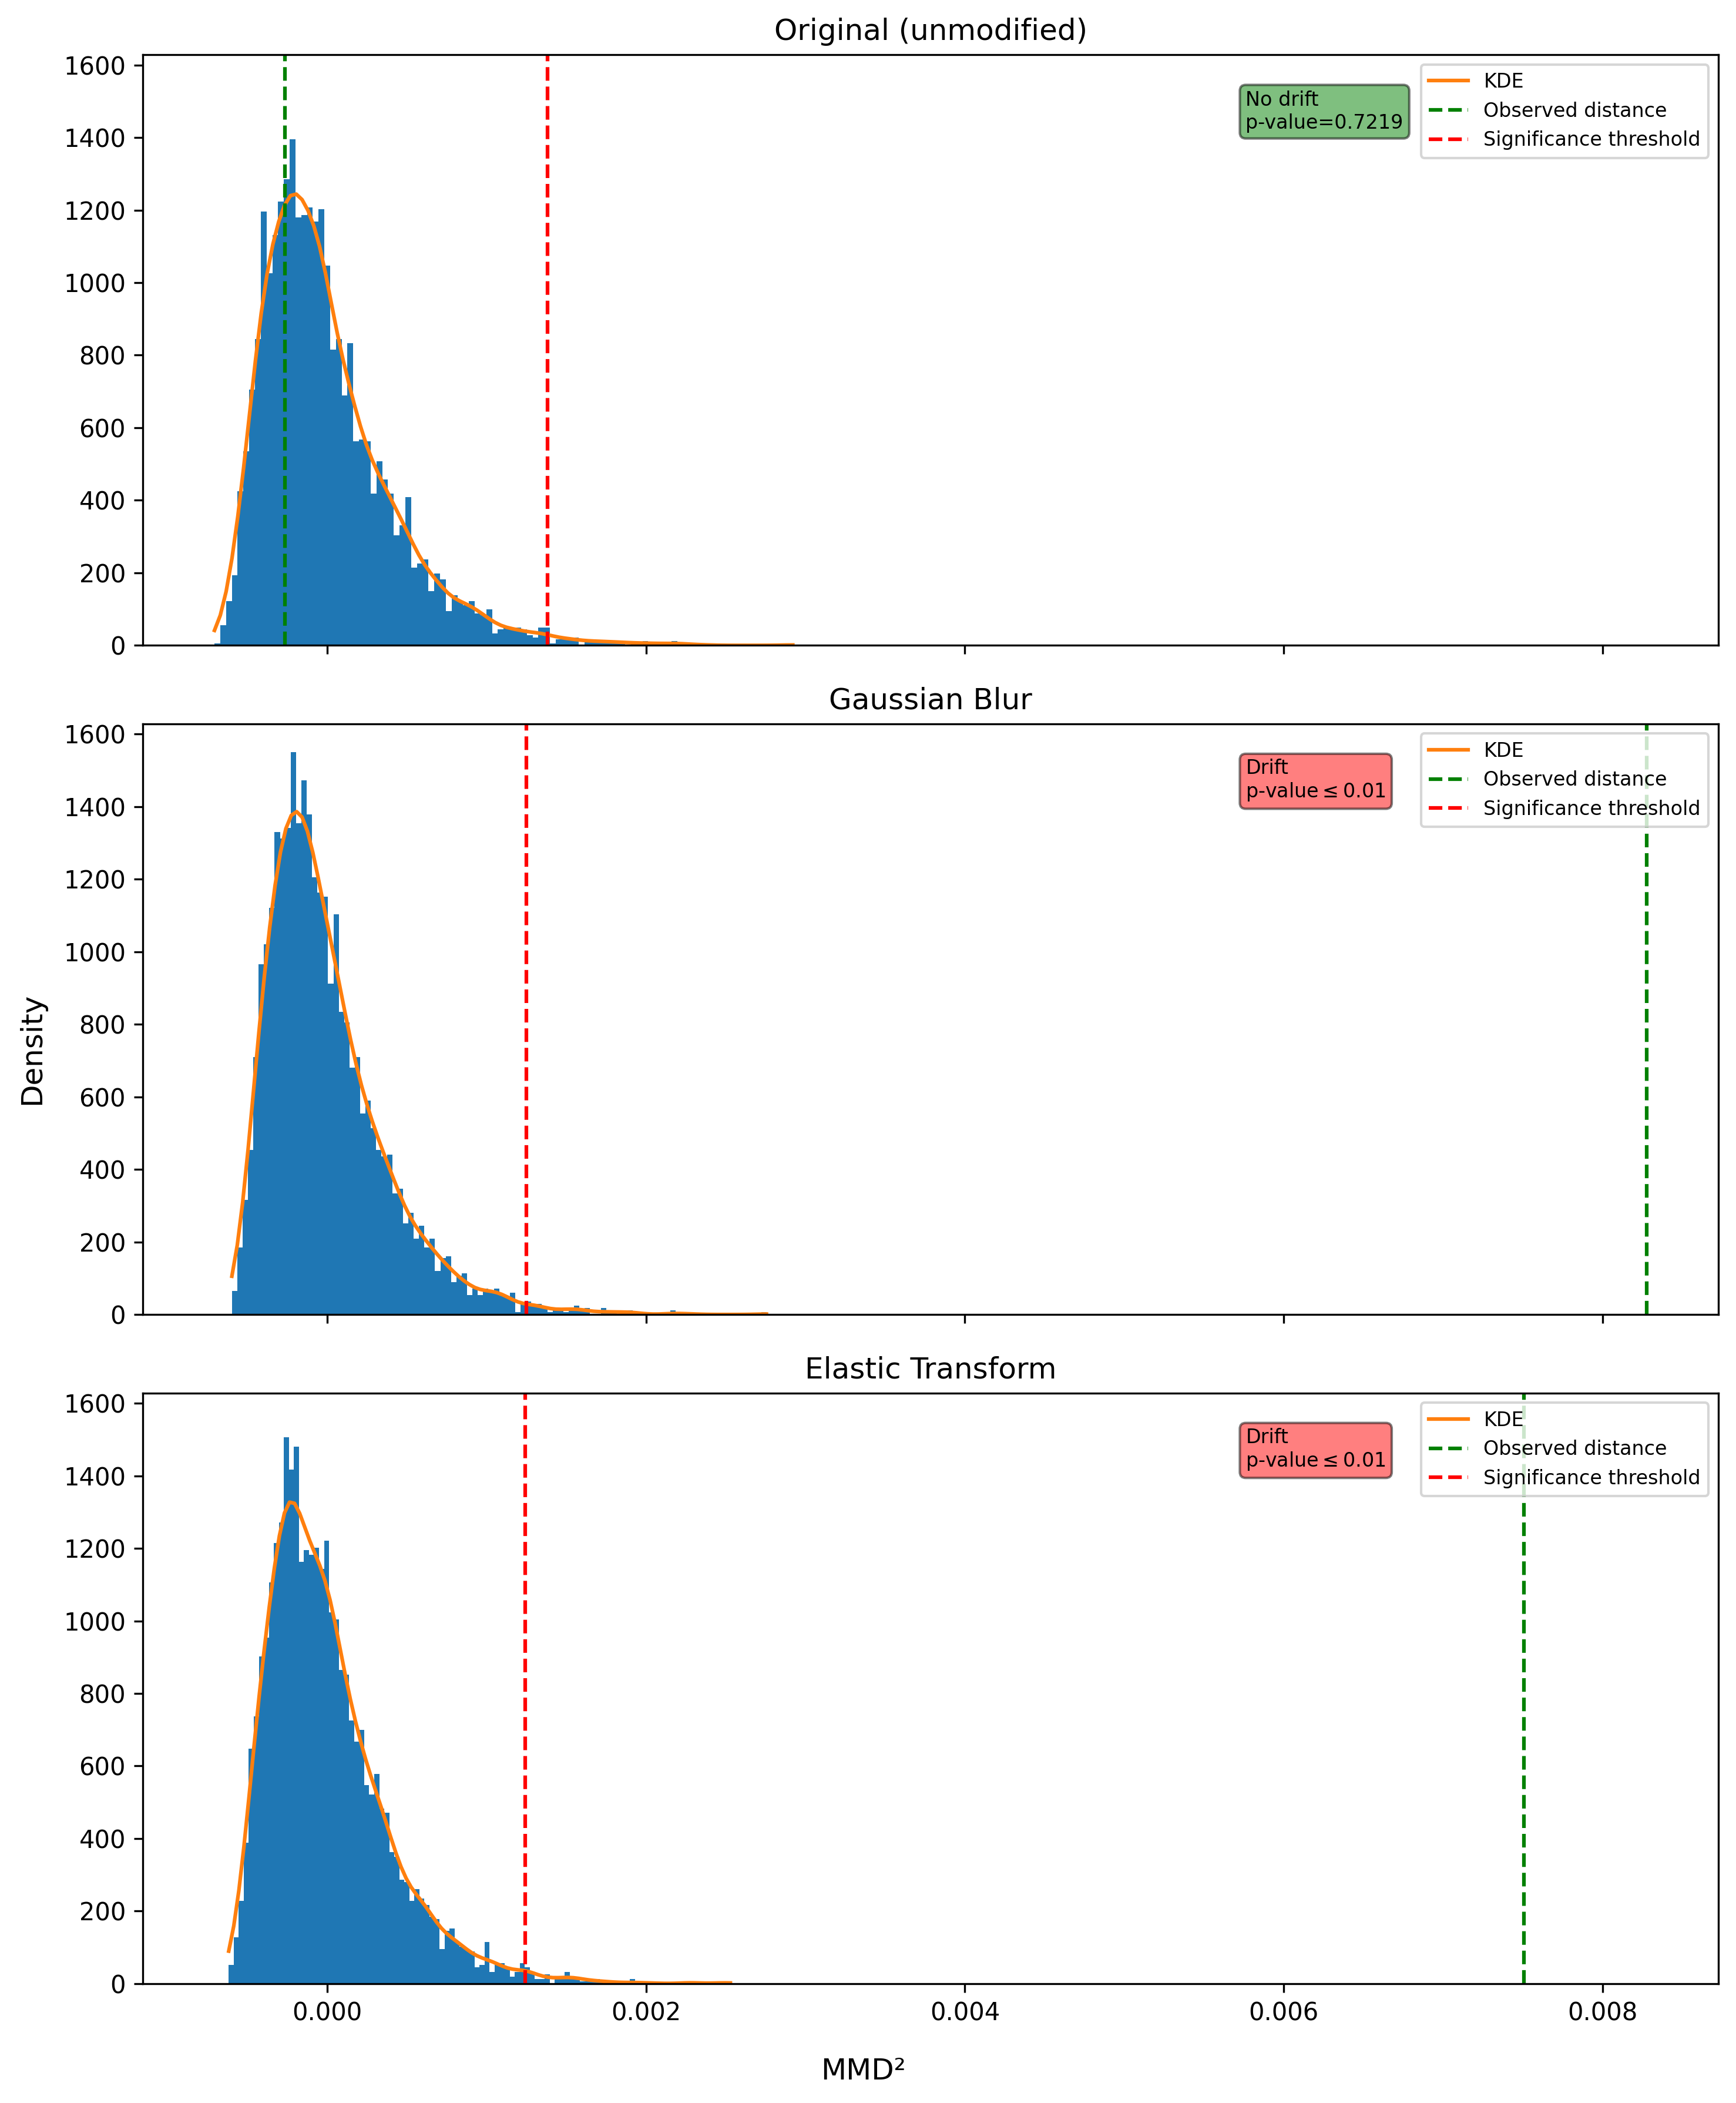

In [29]:
num_bins = 100
x_values = 100
num_percentile = 100 - alpha*100

fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10, 12),
    sharex=True,
    sharey=True,
    dpi=300,
)

for ax, (type_, permutation_test) in zip(
    axs.flat,
    permutation_test_logs.items(),
):
    permutation_tests = permutation_test["permuted_statistics"]
    observed_statistic = permutation_test["observed_statistic"]
    p_value = permutation_test["p_value"]

    ax.hist(permutation_tests, bins=num_bins, density=True)
    xs = np.linspace(min(permutation_tests), max(permutation_tests), num=x_values)
    permutation_tests_density = gaussian_kde(permutation_tests).evaluate(xs)
    ax.plot(xs, permutation_tests_density, label="KDE")
    ax.axvline(observed_statistic, color="green", linestyle="--", label="Observed distance")
    ax.set_title(type_)
    drift = p_value <= alpha
    drift_str = f"Drift\np-value$\leq${alpha}" if drift else f"No drift\np-value={round(p_value, 4)}"
    ax.text(
        0.7,
        0.875,
        drift_str,
        transform=ax.transAxes,
        fontsize=8,
        bbox={"boxstyle": "round", "facecolor": "red" if drift else "green", "alpha": 0.5},
    )
    percentile = np.percentile(permutation_tests, q=num_percentile)
    ax.axvline(percentile, color="red", linestyle="--", label="Significance threshold")
    ax.legend(fontsize=8, loc="upper right")

fig.supxlabel("MMD²")
fig.supylabel("Density")
fig.tight_layout()
plt.show()

```{bibliography}
:filter: docname in docnames
```